SYSC 4415 - Assignment 3B - 2021

# Set-up
Before running any of the cells use GPU accelerator by going to **Runtime** -> **Change runtype type** -> Select **GPU** for the hardware accelerator

Only do this when you plan to run training as if you leave it idle for too long you may run out of resources.

## Download Files

Run the following cells to download the required data to complete the assignment.




In [1]:
#Follow the instructions displayed in the output
import io
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
from zipfile import ZipFile

#File downloader
def zip_downloader(file_id):
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    _, done = downloader.next_chunk()
  #Extract zip file
  with ZipFile(downloaded) as zipf:
      zipf.extractall()

#Authorize user  
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [2]:
#Download  files
zip_downloader("1oXbRYy7_GRetrv1U-kCLgXQo_OgVSIK3") #annotations
zip_downloader("1CZYJI2KJWZnLy7B62LUX3cAYpyn9TLEL")#images

##Install Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="400">

Detectron2 is Facebook AI Research's next generation library that provides state-of-the-art detection and segmentation algorithms. We will employ some some basics features of detectron2, including the following:
* Run inference on images with an existing detectron2 model
* Train a detectron2 model on a new dataset

This is built off of pytorch, which is a open source machine learning framework similar to Keras.

Reference the [documentation](https://detectron2.readthedocs.io/en/latest/) for detailed docmentation of dectctron2 usage.


Adapted from this [colab tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=PIbAM2pv-urF).

In [3]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
#Install MTCNN Network
!pip install mtcnn
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=d6de3116e20ae09479ed98d844a3452fecc0682b691cf55c99aecaa7a935f074
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 747 kB/s 
     |████████████████████████████████| 145 kB 5.3 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 130 kB 35.2 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 749 kB 39.7 MB/s 
     |████████████████████████████████

     |████████████████████████████████| 2.3 MB 5.4 MB/s 


In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random,copy
from google.colab.patches import cv2_imshow

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper,build_detection_train_loader,build_detection_test_loader, MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

#Load MTCNN network
from mtcnn.mtcnn import MTCNN

## Load Dataset

We are going use the dectron2 dataloader functions to load our annotations (the ones you completed as part of assignment 3A). The annotations have been saved in COCO format. This is a common format to save annotations. 

There are 4 datasets:

1. `dataset_face`: this contains only face annotations
2. `dataset_face_1`: this is a second set of face annotations for the same images (different annotators)
3. `dataset_head`: this contains only head annotations
4. `dataset_head_1`: this is a second set of head annotations for the same images (different annotators)

The `dataset_*` variable contains a list of dicts with the following categories:

* `file_name`: the full path to the image file.

* `height`, `width`: integer. The shape of the image.

* `image_id` (str or int): a unique id that identifies this image. Required by many evaluators to identify the images, but a dataset may use it for different purposes.

* `annotations` (list[dict]): Required by instance detection/segmentation or keypoint detection tasks. Each dict corresponds to annotations of one instance in this image (in our case we only have one annotation per image):

  * `bbox` (list[float], required): list of 4 numbers representing the bounding box of the instance.

  * `category_id` (int, required): an integer in the range [0, num_categories-1] representing the category label.

In [2]:
#Register the datasets; whenever we reference the datasets we will use the names defined here
register_coco_instances("dataset_face_train", {}, "annotations_train/instances_face_train.json","Neonate Face Dataset")
register_coco_instances("dataset_face_train_1", {}, "annotations_train/instances_face_train_1.json","Neonate Face Dataset")
register_coco_instances("dataset_head_train", {}, "annotations_train/instances_head_train.json","Neonate Face Dataset")
register_coco_instances("dataset_head_train_1", {}, "annotations_train/instances_head_train_1.json","Neonate Face Dataset")
register_coco_instances("dataset_face_val", {}, "annotations_train/instances_face_val.json","Neonate Face Dataset")
register_coco_instances("dataset_face_val_1", {}, "annotations_train/instances_face_val_1.json","Neonate Face Dataset")
register_coco_instances("dataset_head_val", {}, "annotations_train/instances_head_val.json","Neonate Face Dataset")
register_coco_instances("dataset_head_val_1", {}, "annotations_train/instances_head_val_1.json","Neonate Face Dataset")

In [3]:
#Reorder duplicate annotations to match first
def reorder_data(dataset,dataset_1):
  original = [d['file_name'] for d in dataset]
  duplicates = [d['file_name'] for d in dataset_1]
  inds = [duplicates.index(f) for f in original]
  return list(np.array(dataset_1)[inds])
#Provide the dataset in a dictonary format 
dataset_face = DatasetCatalog.get("dataset_face_train") + DatasetCatalog.get("dataset_face_val")
dataset_face_1 = DatasetCatalog.get("dataset_face_train_1") + DatasetCatalog.get("dataset_face_val_1")
dataset_face_1 = reorder_data(dataset_face,dataset_face_1)
dataset_head = DatasetCatalog.get("dataset_head_train") + DatasetCatalog.get("dataset_head_val")
dataset_head_1 = DatasetCatalog.get("dataset_head_train_1") + DatasetCatalog.get("dataset_head_val_1")
dataset_head_1 = reorder_data(dataset_head,dataset_head_1)
metadata_face = MetadataCatalog.get("dataset_face_train")
metadata_head = MetadataCatalog.get("dataset_head_train")

[12/07 16:21:59 d2.data.datasets.coco]: Loaded 711 images in COCO format from annotations_train/instances_face_train.json
[12/07 16:21:59 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_face_val.json
[12/07 16:22:00 d2.data.datasets.coco]: Loaded 711 images in COCO format from annotations_train/instances_face_train_1.json
[12/07 16:22:00 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_face_val_1.json
WARNING [12/07 16:22:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/07 16:22:00 d2.data.datasets.coco]: Loaded 711 images in COCO format from annotations_train/instances_head_train.json
WARNING [12/07 16:22:00 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/07 16:22:00 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_head_val

## Visualize Data

We are going to use the dectron2 visualizer functions to visualize the bounding boxes. The cell below shows an example of how to use this function on the ground truth annotations. When we load images using `cv2.imread` the image loads in BRG. We must reverse the order of the colour channels from BRG to RGB to load it into the `Visualizer` function. We then reverse it again to properly display it in `cv2_imshow`. To reverse the order of colour channels we can slice the image using `[:, :, ::-1]`

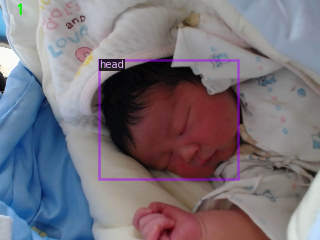

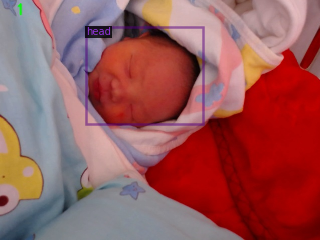

In [4]:
for d in np.array(dataset_head)[329:331]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_head,scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# Assignment Questions


## Q1) Annotator Agreement (4)

With any labelling task there is some variation that comes from differences between annotators. The degree of agreement among independent observers is called inter-rater reliability. 

For our training data each image was labelled by two independent annotators. One set of annotations is stored in `dataset_{face}/{head}` and its pair of annotations is stored in `dataset_{face}/{head}_1`. We would like to measure the inter-rater reliability for our dataset for both the face and head annotations. This is possible by calculating the IoU between the two annotations for each image.

**Questions:**
1. Calculate the average IoU across all the images for both face and head annotations
2. Plot a histogram showing the distribution of IoU scores for both face and head annotations
3. Using the visualizing function, plot an example of an image with annotations that have an IoU less than 0.7 for both face and head annotations
4. **Discussion**: Between the face and head annotations, which type has a lower inter-rater reliability? Give an example of one factor that may lead to poor inter-rater reliability in the context of image annotation.

**NOTE**

* Use the provided function to calculate IoU; it takes two parameters, one for each bbox list  
* To access the annotations from the dataset: `dataset_{face}/{head}['annotations'][#][0]['bbox']`
* You should compare the annotations from `dataset_{face}/{head}` and `dataset_{face}/{head}_1` directly; the order of the images are the same 
* Warning: Some images may not have annotations, in this case the corresponding `annotation` field will be an empty list; you need to implement a check to make sure an annotation exists in both `dataset_{face}/{head}` and `dataset_{face}/{head}_1`




In [5]:
def IoU(a, b):  
  dx = min(a[0]+a[2], b[0]+b[2]) - max(a[0], b[0])
  dy = min(a[1]+a[3], b[1]+b[3]) - max(a[1], b[1])
  if (dx>=0) and (dy>=0):
    interArea = dx*dy
  else:
    interArea = 0
  boxAArea = a[2]*a[3]
  boxBArea = b[2]*b[3]
  return interArea / (boxAArea + boxBArea - interArea)

In [6]:
#Solution here:
import matplotlib.pyplot as plt

# Calculate IoU for all images and store the results in lists
iou_face = []
iou_head = []
dataset_length = max(len(dataset_face), len(dataset_face_1), 
                     len(dataset_head), len(dataset_head_1))

plot_image = True

# Iterate over the datasets (assumes equal dataset lengths)
for i in range(dataset_length):
  # Make sure we actually have annotations to work with
  
  # You gave the wrong list access command in the instructions.
  # It needs to be dataset_{face}/{head}[#]['annotations'][0]['bbox']
  # and not dataset_{face}/{head}['annotations'][#][0]['bbox']
  if len(dataset_face[i]['annotations']) != 0 and \
  len(dataset_face_1[i]['annotations']) != 0 and \
  len(dataset_head[i]['annotations']) != 0 and \
  len(dataset_head_1[i]['annotations']) != 0:
    iou_face.append(IoU(dataset_face[i]['annotations'][0]['bbox'], 
                 dataset_face_1[i]['annotations'][0]['bbox']))
    iou_head.append(IoU(dataset_head[i]['annotations'][0]['bbox'], 
                 dataset_head_1[i]['annotations'][0]['bbox']))


# 1) Calculate IoU averages for all images for both face and head annotations
average_face = sum(iou_face) / len(iou_face)
average_head = sum(iou_head) / len(iou_head)

print(f'Average IoU for face annotations is {average_face}')
print(f'Average IoU for head annotations is {average_head}')


Average IoU for face annotations is 0.7068293490856281
Average IoU for head annotations is 0.8960162490043285


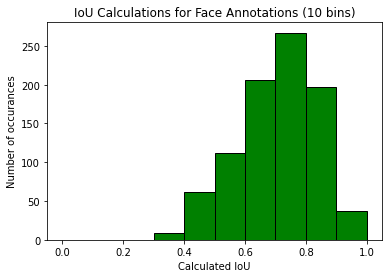

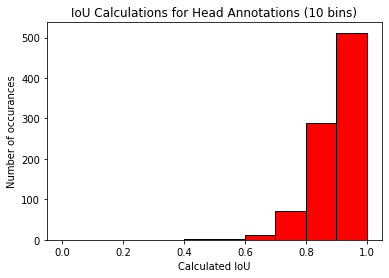

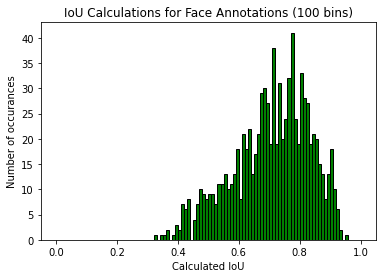

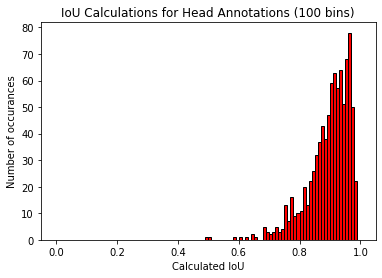

In [7]:
# 2) Plot a histogram showing the distribution of IoU scores for 
#    both face and head annotations
histo_bins = (0, 1)


# Show the graphs with 10 bins
plt.hist(iou_face, bins=10, range=histo_bins, edgecolor='black', color="Green") 
plt.xlabel('Calculated IoU')
plt.ylabel('Number of occurances')
plt.title('IoU Calculations for Face Annotations (10 bins)')
plt.show()

plt.hist(iou_head, bins=10, range=histo_bins, edgecolor='black', color="Red")
plt.xlabel('Calculated IoU')
plt.ylabel('Number of occurances')
plt.title('IoU Calculations for Head Annotations (10 bins)')
plt.show()


#Show the graphs with 100 bins
plt.hist(iou_face, bins=100, range=histo_bins, edgecolor='black', color="Green") 
plt.xlabel('Calculated IoU')
plt.ylabel('Number of occurances')
plt.title('IoU Calculations for Face Annotations (100 bins)')
plt.show()

plt.hist(iou_head, bins=100, range=histo_bins, edgecolor='black', color="Red")
plt.xlabel('Calculated IoU')
plt.ylabel('Number of occurances')
plt.title('IoU Calculations for Head Annotations (100 bins)')
plt.show()

Image with IoU < 0.7 for both face and head annotations:


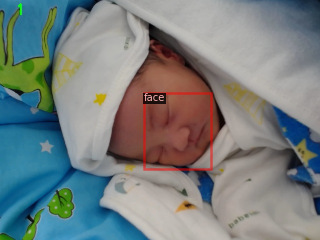

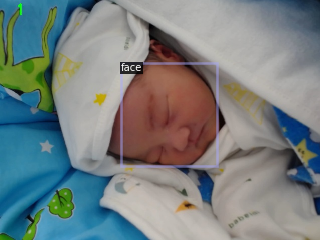

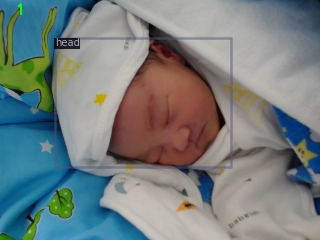

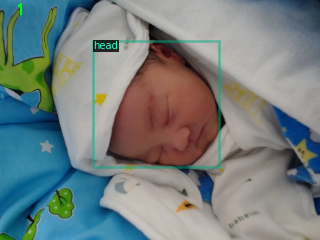

In [8]:
# 3) Using the visualizing function, plot an example of an image with 
#    annotations that have an IoU less than 0.7 for both face and head
#    annotations
for j in range(len(iou_face)):
  if plot_image and iou_face[j] < 0.7 and iou_head[j] < 0.7:
      plot_image = False
      print("Image with IoU < 0.7 for both face and head annotations:")
      img = cv2.imread(dataset_face[j]["file_name"])
      visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_face,scale=0.5)
      out = visualizer.draw_dataset_dict(dataset_face[j])
      cv2_imshow(out.get_image()[:, :, ::-1])

      visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_face,scale=0.5)
      out = visualizer.draw_dataset_dict(dataset_face_1[j])
      cv2_imshow(out.get_image()[:, :, ::-1])

      visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_head,scale=0.5)
      out = visualizer.draw_dataset_dict(dataset_head[j])
      cv2_imshow(out.get_image()[:, :, ::-1])

      visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_head,scale=0.5)
      out = visualizer.draw_dataset_dict(dataset_head_1[j])
      cv2_imshow(out.get_image()[:, :, ::-1])

**Q1 Discusion here**

4) Unsurprisingly to me, face annotations have a lower average IoU compared to head annotations (0.89 for head vs 0.70 for face). Image classification is difficult because what we are attempting to classify is subjective. My idea of a face including the eyes, eyebrows, nose, chin, and mouth might differ from someone elses idea of a face being the forehead, ears, mouth, node, eyebrows, and eyes of a human. 

The issue is that without extremly precise instructions (e.g. This is a face, it should contain the eyebrows, eyes, nose, mouth, cheeks, and chin. It should not contain the forehead, ears, hair, or top of the babies head), human classifiers are going to let their subjectivity impact their annotations. The result of this is lower calculated IoUs between annotations from one individual compared to another. In this specific case, a head is a more generally understanded concept compared to a face. In the video presentation for Assignment 3A, the demostration for capturing a head was clearer than the demonstration for capturing a face (details for the head included trying to capture as much of the hair as possible, going to the edges of the spherical head shape, etc., where as very little detail was given about what a face is). 

I think the video overview played a significant factor and results in the IoU averages being quite significantly different between the two annotation types. In short, human subjectivity will likely cause a problem in image annotation and it is a difficult problem to address. 

## Q2) Trying MTCNN (2)

We want to asses how well MTCNN (used in Assignment 2) performs on our dataset. 

**Questions:**
1. Test MTCNN on the `dataset_face_1` for the first 100 images and report the number of detections that were correctly made (IoU > 0.5). 
2. Why do you think the performance of MTCNN is poor on our dataset?

A code example is shown below illustrating how to use the MTCNN functions. Be sure to the reverse the order of the colour channels before predicting bounding boxes.




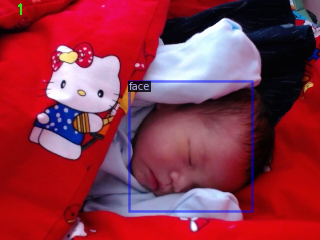

In [9]:
mtcnn = MTCNN()
d = np.array(dataset_face_1)[0]
img = cv2.imread(d["file_name"])
faces = mtcnn.detect_faces(img[:, :, ::-1])
for f in faces:
  d['annotations'][0]['bbox'] = f['box']
  visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_face,scale=0.5)
  out = visualizer.draw_dataset_dict(d)
  cv2_imshow(out.get_image()[:, :, ::-1])

In [10]:
#Solution here:
# 1) Test MTCNN on dataset_face_1 and report the number of IoU > 0.5 detections
correct_detections = 0

for i in range(100):
  d = np.array(dataset_face_1)[i]
  img = cv2.imread(d["file_name"])
  faces = mtcnn.detect_faces(img[:, :, ::-1])
  for face in faces:
    if IoU(dataset_face_1[i]['annotations'][0]['bbox'], face['box']) > 0.5:
      correct_detections += 1

print(f'MTCCN correctly predicted {correct_detections} faces (IoU > 0.5)')

MTCCN correctly predicted 4 faces (IoU > 0.5)


**Q2 Discussion here**

2) Wow, what a terrible result! Only having a calculated IoU > 0.5 for 4 out of 100 images indicates that MTCNN is very poor at detecting faces in this instance. 

I suppose this is not that surprising a result if we recall that MTCNN is trained to work well for forward-facing faces, of which our dataset is not prodominent in. It also specializes in face alignment, however the faces in our dataset are still developing as they are of babies. The overall features of a babies face are different compared to that of a child or adult, as babies observe the most variance in their faces (making it difficult to train for extensively). We also need to recall what I mentioned previously about human subjectivity and the result annotations on our dataset. Comparing the MTCNN results from Assignment 2, the faces identified include everything except the ears and hair, where as our dataset contains examples where the faces stop short of the forehead, reducing the overall size of our bounding box. This variance likely leads to a lower IoU score, hence the lower result. Combining all of these factors together is likely why the MTCNN classifier performs poorly on our dataset. 

## Q3) Faster R-CNN (3)

Let's examine the Faster R-CNN architecture for our object detection task. This differs from MTCNN from the previous assignment in that it is fully differentiable (trainable end-to-end) and can make use of pre-trained models for feature extraction. 

<img src="https://tryolabs.imgix.net/assets/blog/2018-01-18-faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/fasterrcnn-architecture.png?auto=format&fit=max&w=3840" width="700">

Read this [article](https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection) about Faster R-CNN and answer the following **questions**.

1. How does the Faster R-CNN object detection framework solve "variable length" output problem?
2. What is the role of the base network?
3. What are the outputs of the RPN stage for Faster R-CNN and what is the total number of output channels?


**Q3 Discussion here**

1.   The issue of the variable length output problem is solved using the concept of anchors. An anchor in this context is a reference bounding box of a fixed size. These get distributed uniformly on the original image. We then check at each anchor if the anchor contains the relevant object and how the anchor could be adjusted to better fit the relevant object. Since we do this with a fixed number of anchors, we do not end up with a variable length output, but instead an output of a fixed and exepected length each time. The set of anchors created is defined by the number of points in the feature map retrieved from the CNN base network alongside a chosen size for the anchors, and a set of ratios between the width and height of the bounding boxes.

2.   The base network, in this instance a pretrained CNN, is responsible for the task of classification. The input images get passed to the base network as arrays containing the dimensions of the images which are then processed through the pre-trained CNN. At an intermeditate layer we extract the features as a convoluition feature map that in its depth has encoded the information for the image while maintaining the coordinates of the detected objects it has encoded relative to the original image. That is then used in the next step of Faster R-CNN. The article goes into more detail about ZF and VGG but since the questions is just asking what the role of the base network is, I'm going to assume it isn't necessary to discuss those here. 

3.   The outputs of the RPN stage are proposals for objects in the image. For each anchor, there are two outputs. The first output is the probability that an anchor contains an object of interest (the article refers to it as an objectness score). This output isn't considered with classifying the object to a class, but rather will just determine if that area of the image is an object and not the background. The second output is the bounding box regression that is used to adjust the anchors such that they are closer to the objects they are predicting. The number of output channels will depend on the number of anchors being used, but it will be the result of $output_{channels} = 6k$ where $k$ is the number of anchors.



## Q4) Train! (2)

Now, let's train our own object detection model! We will start by training a head detection model. The code to train the model has already been provided, however you should adjust the various parameters and try to achieve the best performance you can.

The parameters you can adjust are:


1. `base_model`: this is the path of the pre-trained model that you will use. The list of models can be found [here](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md). Click on the link to model you want, click the three dots beside the github path and copy the path to the model. Paste this in the form without including the 'configs/' at the begininng of the path.
  *i.e. if you copied configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml only keep COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml*
2. `batch_size`: controls number of images per batch
3. `iterations`: number of training iterations to run
4. `learning_rate`: controls the learning rate
5. `learning_rate_decay`: list of iteration numbers where learning rate is to be reduced

**Discuss** your reasoning for your choice of base model.


In [11]:
#@markdown Fill in this form with your parameters and run the cell.
base_model = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml" #@param {type: "string"}
batch_size =  6#@param {type: "integer"}
iterations =  500#@param {type: "integer"}
learning_rate = 0.0002  #@param {type: "number"}
learning_rate_decay =   []#@param
cfg = get_cfg()

#Load pre-trained model
cfg.merge_from_file(model_zoo.get_config_file(base_model))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_model) 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 #set number of classes
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 

#Load training set and validation set
cfg.DATASETS.TRAIN = ("dataset_head_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

#Adjust Solver parameters
cfg.SOLVER.BASE_LR = learning_rate
cfg.SOLVER.MAX_ITER = iterations  
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.STEPS = learning_rate_decay    # do not decay learning rate

cfg.OUTPUT_DIR = 'output_head'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [12]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/07 16:25:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:08, 28.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pre

[12/07 16:25:11 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/07 16:27:04 d2.utils.events]:  eta: 0:42:56  iter: 19  total_loss: 0.8555  loss_cls: 0.6661  loss_box_reg: 0.169  loss_rpn_cls: 0.00975  loss_rpn_loc: 0.008915  time: 5.6147  data_time: 0.0778  lr: 7.7924e-06  max_mem: 7762M
[12/07 16:29:02 d2.utils.events]:  eta: 0:46:48  iter: 39  total_loss: 0.7006  loss_cls: 0.5324  loss_box_reg: 0.167  loss_rpn_cls: 0.007247  loss_rpn_loc: 0.008652  time: 5.7624  data_time: 0.0696  lr: 1.5784e-05  max_mem: 7762M
[12/07 16:30:57 d2.utils.events]:  eta: 0:44:58  iter: 59  total_loss: 0.5167  loss_cls: 0.3324  loss_box_reg: 0.1624  loss_rpn_cls: 0.0108  loss_rpn_loc: 0.00955  time: 5.7620  data_time: 0.0651  lr: 2.3776e-05  max_mem: 7762M
[12/07 16:32:51 d2.utils.events]:  eta: 0:42:55  iter: 79  total_loss: 0.4047  loss_cls: 0.2181  loss_box_reg: 0.1679  loss_rpn_cls: 0.006249  loss_rpn_loc: 0.008384  time: 5.7372  data_time: 0.0685  lr: 3.1768e-05  max_mem: 7762M
[12/07 16:34:49 d2.utils.events]:  eta: 0:40:56  iter: 99  total_loss: 0.3444  los

In [ ]:
# May run out of memory when using colab, run this to clear it and then re-run
# the training above. 
import gc

del trainer
gc.collect()

**Q4 Discusion here**

Of the models available for detections (there were many models on that list but not all were compitable with what we are attempting to accomplish with this assingment), I naturally wanted to grab a model that performed the best. I knew from reading the information about the different backbone options that an FPN backed model is the best for speed/accuracy tradeoff. I also learned that models with a 1x lr sched were considered undertrained. As such I looked for models with a 3x lr. My options were between R101-FPN and X101-FPN. Of these options, X101-FPN is objectively the better choice, however it is only 1% more accurate compared to R101-FPN 220% but comes at the cost of a training speed being 2.2 times slower than R101-FPN, using 1.6 times the training memory and having a 1.92 times slower inference time. As such, in order to better balance the speed/accuracy tradeoff I ultimately chose R101-FPN as my model.  

Batch size was set to 6 since that was the most I could squeeze out of the GPU. I left the learning rate unchanged from the provided value and also did not add a learning decay. For the number of iterations, I tried to iteratively determine an appropriate value by going in increments of 100 until the benefit of additional iterations were not observed in the total loss. I was worried about overfitting my model so I did not want to push the number of iterations to be too high (some examples online used thousands of iterations), but it depends on the dataset. Our dataset is not the largest, but I still believe 500 iterations should be enough to sufficiently train the model while avoiding overfitting to the training data. 

## Q5) Plot training graphs (2)

We want to see how the training of our model went. The training module keeps track of the different losses for the Faster R-CNN and saves this information in a `metrics.json` file. The code below loads this file as a `pandas` dataframe. In seperate plots, plot a line graph of the `loss_box_reg` and `loss_cls` (y-axis) against the epoch training number (x-axis).

**Question:** What do these figures represent? 

In [13]:
import pandas as pd
df = pd.read_json('output_head/metrics.json', lines=True)

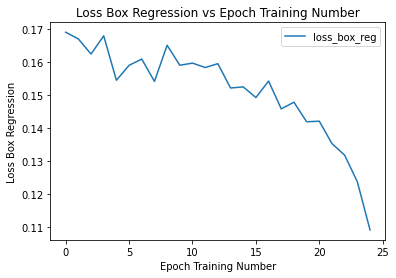

In [14]:
#Solution here:
df.plot(kind='line', y='loss_box_reg', 
        title='Loss Box Regression vs Epoch Training Number', 
        xlabel='Epoch Training Number',
        ylabel='Loss Box Regression')

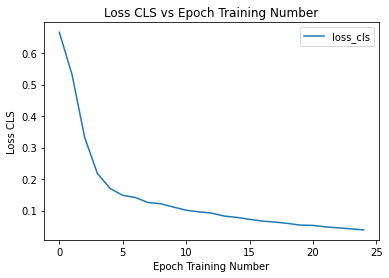

In [15]:
df.plot.line(y='loss_cls',
             title='Loss CLS vs Epoch Training Number',
             xlabel='Epoch Training Number',
             ylabel='Loss CLS')

**Q5 Discusion here**

The first figure represents the loss reltaed to the prediction of the bounding boxes coordinates within our image. We can see from the figure that towards the beginning of the training the loss was quite sporatic, but it quickly began to decrease towards the end of our training.

The second figure represents the loss related to the predictions of object classes within the bounding boxes. As we can see from the figure, towards the beginning of the training the loss high but it quickly began to drop and as the number of epochs increased, the decrease rduced gradually.


## Q6) Test! (5)

Now that we have a trained model, we want to test its performance on unseen (*independent test*) data. A validation set and the required code to evaluate the model has been provided. We will use the detection evaluation metrics used by [COCO](https://cocodataset.org/#detection-eval) to evaluate our models. 

You must set a threshold for the classification confidence required to consider a detection as positive. You can test multiple thresholds to find the ideal one. 

**Questions:**
1. Run the cells below and the performance of your model on the validation set will be printed out. This will be a `dict` with the metric short-form name and th score. The ones that will be printed out are:

* Average Precision (AP):
  * AP: AP at IoU=.50:.05:.95 
  * AP50: AP at IoU=.50 
  * AP75: AP at IoU=.75
* AP Across Scales:
  * APs: AP for small objects
  * APm: AP for medium objects
  * APl: AP for large objects

2. Using the descriptions from [COCO](https://cocodataset.org/#detection-eval) describe what each type of AP represents.
3. Why do you think that the AP metric is lower when evaluated at IoU=0.75 compared to IoU=0.5?
4. The validation set was derived from the same dataset as the training set; if the test set contains images of babies that never appeared in the training data, how would the performance of your model compare on the test set?
5. Visualize any three examples of your model's detections over the `dataset_head`. You can make a prediction over an image by running `predictor(im)` which takes an image array as input.

In [16]:
#@markdown Fill in this form with your parameter and run the cell.
threshold_score = 0.7 #@param {type: "number"}
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold_score

In [17]:
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_head_val", output_dir="./output_head")
val_loader = build_detection_test_loader(cfg, "dataset_head_val")
val_results_head = inference_on_dataset(predictor.model, val_loader, evaluator)
print(val_results_head)

WARNING [12/07 17:17:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/07 17:17:05 d2.data.datasets.coco]: Loaded 178 images in COCO format from annotations_train/instances_head_val.json
[12/07 17:17:05 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    head    | 178          |
|            |              |
[12/07 17:17:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/07 17:17:05 d2.data.common]: Serializing 178 elements to byte tensors and concatenating them all ...
[12/07 17:17:05 d2.data.common]: Serialized dataset takes 0.05 MiB
[12/07 17:17:05 d2.evaluation.evaluator]: Start inference on 178 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/07 17:17:10 d2.evaluation.evaluator]: Inference done 11/178. Dataloading: 0.0017 s/iter. Inference: 0.4332 s/iter. Eval: 0.0003 s/iter. Total: 0.4352 s/iter. ETA=0:01:12
[12/07 17:17:15 d2.evaluation.evaluator]: Inference done 23/178. Dataloading: 0.0022 s/iter. Inference: 0.4331 s/iter. Eval: 0.0003 s/iter. Total: 0.4357 s/iter. ETA=0:01:07
[12/07 17:17:20 d2.evaluation.evaluator]: Inference done 35/178. Dataloading: 0.0023 s/iter. Inference: 0.4336 s/iter. Eval: 0.0003 s/iter. Total: 0.4364 s/iter. ETA=0:01:02
[12/07 17:17:26 d2.evaluation.evaluator]: Inference done 47/178. Dataloading: 0.0023 s/iter. Inference: 0.4347 s/iter. Eval: 0.0003 s/iter. Total: 0.4375 s/iter. ETA=0:00:57
[12/07 17:17:31 d2.evaluation.evaluator]: Inference done 59/178. Dataloading: 0.0023 s/iter. Inference: 0.4358 s/iter. Eval: 0.0003 s/iter. Total: 0.4387 s/iter. ETA=0:00:52
[12/07 17:17:36 d2.evaluation.evaluator]: Inference done 71/178. Dataloading: 0.0023 s/iter. Inference: 0.4366 s/iter. Eval: 0.000

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


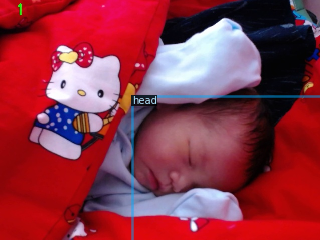

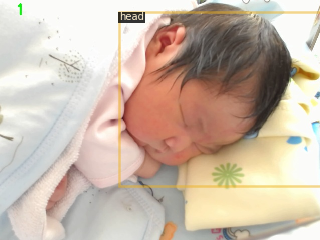

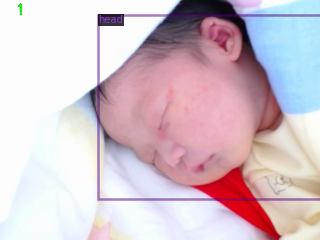

In [18]:
#Solution here:
# Part 5) 
# Visualize any three examples of your model's detections over the dataset_head
d = np.array(dataset_head)
for k in range(3):
  # Make the prediction
  img = cv2.imread(d[k]['file_name'])
  d[k]['annotations'][0]['bbox'] = predictor(img)['instances'].pred_boxes.tensor.cpu().numpy()[0].tolist()
  visualizer = Visualizer(img[:, :, ::-1],metadata=metadata_head,scale=0.5)
  out = visualizer.draw_dataset_dict(d[k])
  cv2_imshow(out.get_image()[:, :, ::-1])

**Q6 Discussion here**

2) 
*   AP: AP at IoU=.50:.05:.95
  *  This is the primary challenge metric. This will be  equal to the lowest value of any other AP metric.
*   AP50: AP at IoU=.50
  *  This is the PASCAL VOC metric. This will represent how often we achieve an IoU of at least 50% over our evaluation.
*   AP75: AP at IoU=.75
  *  This is the strict metric. This will represent how often we achieve an IoU of at least 75% over our evaluation.
*   APs: AP for small objects
  *  This is the AP for small objects: area < 322. This will represent how ofter we are able to detect small objects in our image (should that be what we are checking for and they exist). In our case, this is NaN since we are not checking for small objects. 
*   APm: AP for medium objects
  *  This is the AP for medium objects: 322 < area < 962. This will represent how ofter we are able to detect medium objects in our image (should that be what we are checking for and they exist). In our case, this is NaN since we are not checking for medium objects. 
*   APl: AP for large objects
  *  This is the AP for large objects: area > 962. This will represent how ofter we are able to detect large objects in our image (should that be what we are checking for and they exist). In our case, this is not NaN since we are checking for large objects (i.e. heads).
  



3) The answer is that an IoU of 0.75 is a stricter threshold than an IoU of 0.5. An IoU of 0.5 means that the two annotations are overlap by at least 50%, while an IoU of 75% means they overlap by 75%. We want higher overlap, but that is also more difficult to achieve. Hence why the AP75 metric is lower than the AP50 metric, we only achieved 75% overlap 91.504% of the time versus 50% overlap 98.020% of the time. We have more forgiveness for 50% overlap, so it makes sense for it to be higher.

4) Optimistically, it should perform well on new images if I did a good enough job to not overfit the model to the training data. I would not expect it to perform as well as it did on images derived from the training set, but it should still perform decently enough (better than AP > 0.5). If I did overfit the model, I would expect the AP to be very low (even potentially 0) as the model would be unable to make accurate predictions because the images are too different than what it has been overtrained on. 

### Benchmark Predictions 

Now that you've evaluated your model on a validation set, it is time to use the test set. For this assignment, you are provided with a **blind** test set, where you do not know the actual annotations; instead you will submit your predictions that we will then use to evaluate your model against the gold-standard annotations. 

Run the cell below and when you submit your assignment, in addition to submitting your notebook, make sure to submit:


1.   `output_head/instances_predictions.pth` (file containing your predictions)
2.   `output_head/model_final.pth` (file containing your model weights, in case we need to re-run it)

You can download these files by going into **Files** tab, navigating to the proper folder, clicking on the three dots next to the file name and clicking download. 



In [19]:
import torch
register_coco_instances("dataset_head_test_no_annotations", {}, "instances_head_test.json","Neonate Face Dataset")
evaluator = COCOEvaluator("dataset_head_test_no_annotations", output_dir="./output_head")
test_loader = torch.load('test_loader.pth')
test_results = inference_on_dataset(predictor.model, test_loader,evaluator)

[12/07 17:19:40 d2.evaluation.evaluator]: Start inference on 762 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/07 17:19:45 d2.evaluation.evaluator]: Inference done 11/762. Dataloading: 0.0018 s/iter. Inference: 0.4275 s/iter. Eval: 0.0003 s/iter. Total: 0.4297 s/iter. ETA=0:05:22
[12/07 17:19:50 d2.evaluation.evaluator]: Inference done 23/762. Dataloading: 0.0023 s/iter. Inference: 0.4267 s/iter. Eval: 0.0003 s/iter. Total: 0.4294 s/iter. ETA=0:05:17
[12/07 17:19:55 d2.evaluation.evaluator]: Inference done 35/762. Dataloading: 0.0022 s/iter. Inference: 0.4262 s/iter. Eval: 0.0003 s/iter. Total: 0.4289 s/iter. ETA=0:05:11
[12/07 17:20:00 d2.evaluation.evaluator]: Inference done 47/762. Dataloading: 0.0023 s/iter. Inference: 0.4265 s/iter. Eval: 0.0003 s/iter. Total: 0.4293 s/iter. ETA=0:05:06
[12/07 17:20:05 d2.evaluation.evaluator]: Inference done 59/762. Dataloading: 0.0022 s/iter. Inference: 0.4268 s/iter. Eval: 0.0003 s/iter. Total: 0.4296 s/iter. ETA=0:05:01
[12/07 17:20:10 d2.evaluation.evaluator]: Inference done 71/762. Dataloading: 0.0022 s/iter. Inference: 0.4276 s/iter. Eval: 0.000

## Q7) Face detection model (2)

Train and test a **face** detection model using the same configuration as the **head** detection model by running the code below. 

**Question:** Why do you you think there is a diffence in performance between this model compared to the head detection model?

In [20]:
#Train
cfg.DATASETS.TRAIN = ("dataset_face_train")
cfg.OUTPUT_DIR = 'output_face'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
#Test
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("dataset_face_val", output_dir="./output_face")
val_loader = build_detection_test_loader(cfg, "dataset_face_val")
val_results_face = inference_on_dataset(predictor.model, val_loader, evaluator)
print(val_results_face)

[12/07 17:27:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/07 17:29:19 d2.utils.events]:  eta: 0:48:33  iter: 19  total_loss: 0.2627  loss_cls: 0.08906  loss_box_reg: 0.1221  loss_rpn_cls: 0.01869  loss_rpn_loc: 0.01176  time: 5.8190  data_time: 0.0784  lr: 7.7924e-06  max_mem: 7866M
[12/07 17:31:18 d2.utils.events]:  eta: 0:46:41  iter: 39  total_loss: 0.2396  loss_cls: 0.08455  loss_box_reg: 0.13  loss_rpn_cls: 0.01594  loss_rpn_loc: 0.01083  time: 5.8817  data_time: 0.0671  lr: 1.5784e-05  max_mem: 7866M
[12/07 17:33:14 d2.utils.events]:  eta: 0:44:41  iter: 59  total_loss: 0.248  loss_cls: 0.08991  loss_box_reg: 0.1293  loss_rpn_cls: 0.01233  loss_rpn_loc: 0.011  time: 5.8613  data_time: 0.0655  lr: 2.3776e-05  max_mem: 7866M
[12/07 17:35:13 d2.utils.events]:  eta: 0:42:42  iter: 79  total_loss: 0.2505  loss_cls: 0.08955  loss_box_reg: 0.1167  loss_rpn_cls: 0.02426  loss_rpn_loc: 0.0113  time: 5.8740  data_time: 0.0673  lr: 3.1768e-05  max_mem: 7866M
[12/07 17:37:14 d2.utils.events]:  eta: 0:40:45  iter: 99  total_loss: 0.2248  loss_cl

**Q7 Discussion here**

I think my arguments made above remain valid here. We are attempting a more difficult classification task, faces are subjective, unique, and do not conform to a defined shape (versus a round shape for a head). Should the face be obstructed, the model will most likely be unable to detect the face and just not make a prediction, resulting in a much lower AP compared to the head model. Where as if a head is slightly obstrcuted, we still may get a prediction if enough of the general shape is detected. I think having a classifier trained to identify features of a face may be more useful in this case, as that might allow for obstructed faces to be predicted with some degree of correctness, but perhaps this is what the model is already doing. Regardless, it has a very low AP and compared to our head model this is clearly much worse.